## Load and set up images

In [1]:
%matplotlib widget
import numpy as np
import xarray as xr
import pandas as pd
import pywt
from skimage.transform import radon, iradon
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.notebook import tqdm

In [2]:
nc_fn = "E:/research_data/2022_harmonic_gravity_waves/preprocessed_images/bore_ex.nc"
ds = xr.open_dataset(nc_fn)
ds['time'] = pd.to_datetime(ds.time)

For easy examples 1 and 3, slice to [:, :2500].

In [3]:
easy_examples = [
    '2018-05-13T17:16',
    '2018-05-19T06:06',
    '2018-08-15T05:05',
    '2019-06-09T07:51',
    '2019-06-09T08:41',
    '2019-07-04T13:25',
    '2019-07-06T12:50',
    '2019-07-06T13:41',
    '2020-06-16T15:38',
]

In [4]:
ds.rad255.shape

(2304, 4064, 61)

In [5]:
ds.sel(time=easy_examples[0],x=2304//2,y=4064//2)

<xarray.Dataset>
Dimensions:    (time: 1)
Coordinates:
    lat        (time) float32 ...
    lon        (time) float32 ...
  * time       (time) datetime64[ns] 2018-05-13T17:16:00
Data variables:
    lunazi     (time) float32 ...
    lunzen     (time) float32 ...
    rad255     (time) float64 ...
    satellite  (time) object ...
    senazi     (time) float32 ...
    senrange   (time) float32 ...
    senzen     (time) float32 ...
    solazi     (time) float32 ...
    solzen     (time) float32 ...

In [6]:
img_array = ds.sel(time=easy_examples[0]).rad255.values

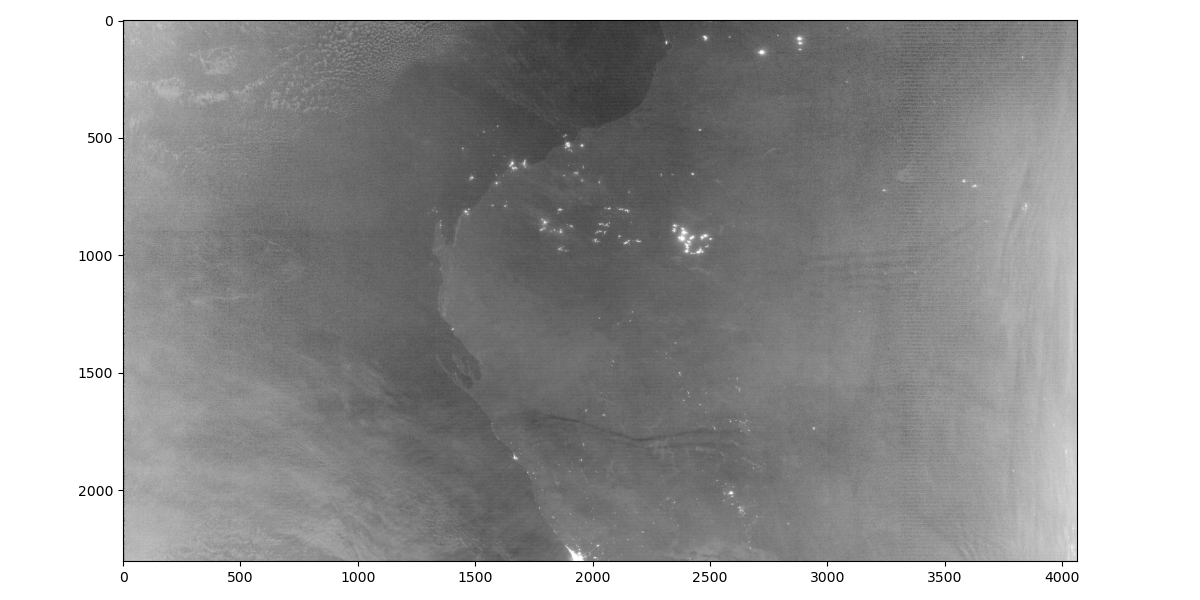

In [7]:
F, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img_array, cmap='gray', clim=(0, 255))
F.tight_layout()

In [97]:
img_crop = img_array[1700:1849, 2300:2449, 0]

In [98]:
img_crop.shape

(149, 149)

In [99]:
class frt(object):
    
    def __init__(self, folded=True):
        self.folded = folded
        self.n_vecs = None
        
    def _cp(self, x, p):
        return x - p*np.round(x / p)
        
    def compute_nvecs(self, p):
        n_vecs = [[0.0, 1.0]]
        for k in range(1, p):
            u_k = np.array((-k, 1))
            n_vecs_cand = []
            dists = []
            for n in range(1, p):
                ak_bk = [self._cp(x, p) for x in np.mod(n*u_k, p)]
                if ak_bk[1] < 0:
                    continue
                n_vecs_cand.append(ak_bk)
                dists.append(np.linalg.norm(ak_bk, ord=np.inf))
            best_vec = n_vecs_cand[np.argmin(dists)]
            if self.folded:
                if best_vec[0] >= 0:
                    n_vecs.append(best_vec)
            else:
                n_vecs.append(best_vec)
        n_vecs.append([1.0, 0.0])
        return n_vecs
    
    def fit(self, img):
        if self.folded:
            self.n = img.shape[0]
            self.p = 2*self.n - 1
        else:
            self.n = self.p = img.shape[0]
        self.n_vecs = self.compute_nvecs(self.p)
        return None
        
    def transform(self, img):
        if len(img.shape) != 2:
            raise ValueError('Must be 2D data')
        if img.shape[0] != img.shape[1]:
            raise ValueError('Input image must be square')
        if img.shape[0] != self.n:
            raise ValueError(f'Input image must be {self.n} x {self.n}')
        
        if self.folded:
            img_folded = np.empty((self.p, self.p))
            img_folded[:self.n, self.n-1:] = img
            img_folded[:self.n, :self.n] = img[:, ::-1]
            img_folded[self.n-1:, self.n-1:] = img[::-1, :]
            img_folded[self.n-1:, :self.n] = img[::-1, ::-1]
            self._img = img_folded - img_folded.mean()
        else:
            self._img = img.copy() - img.mean()

        self.r = np.zeros((self._img.shape[0], len(self.n_vecs)))
        for col, n_vec in enumerate(self.n_vecs):
            for i in range(self.p):
                if n_vec[1] == 0:
                    self.r[:, col] = np.sum(self._img, axis=0)
                else:
                    x_step = -n_vec[1]
                    y_step = n_vec[0]
                    self.r[:, col] += np.roll(self._img[:, int(i * x_step) % self.p], int(i * y_step) % self.p)

        return 1/np.sqrt(self.p) * self.r
        
    def fit_transform(self, img):
        if self.n_vecs is None:
            self.fit(img)
        return self.transform(img)
    
    def inv_transform(self, sino):
        if self.n_vecs is None:
            raise ValueError('Need to first fit to image size')
        
        if not self.folded:
            self.recon = np.zeros((self.n, self.n), dtype=np.float64)
            for col, n_vec in enumerate(self.n_vecs):
                for i in range(self.n):
                    if n_vec[1] == 0:
                        self.recon[i, :] += sino[:, col]
                    else:
                        x_step = -n_vec[1]
                        y_step = n_vec[0]
                        self.recon[:, int(i * x_step) % self.p] += np.roll(sino[:, col], int(-i * y_step) % self.p)
        else:
            self.recon = np.zeros((self.p, self.p), dtype=np.float64)
            for col, n_vec in enumerate(self.n_vecs):
                for i in range(self.p):
                    if n_vec[1] == 0:
                        self.recon[i, :] += sino[:, col]
                    else:
                        x_step = -n_vec[1]
                        y_step = n_vec[0]
                        if n_vec[0] == 0:
                            self.recon[:, int(i * x_step) % self.p] += np.roll(sino[:, col], int(-i * y_step) % self.p)
                        else:
                            self.recon[:, int(i * x_step) % self.p] += np.roll(sino[:, col], int(-i * y_step) % self.p)
                            self.recon[:, int(i * x_step - 1) % self.p] += np.roll(sino[:, col], int(i * y_step) % self.p)
            self.recon = self.recon[:self.n, :self.n][:, ::-1]
        
        return 1/np.sqrt(self.p) * self.recon

In [22]:
test = np.float64(np.reshape(range(1, 10), (3, 3)))

In [23]:
test - test.mean()

array([[-4., -3., -2.],
       [-1.,  0.,  1.],
       [ 2.,  3.,  4.]])

In [24]:
test_frt = frt(folded=False)
sino = test_frt.fit_transform(test)
sino

array([[-5.19615242,  0.        ,  0.        , -1.73205081],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 5.19615242,  0.        ,  0.        ,  1.73205081]])

In [25]:
test_frt.n_vecs

[[0.0, 1.0], [-1.0, 1.0], [1.0, 1.0], [1.0, 0.0]]

In [26]:
test_frt.inv_transform(sino)

array([[-4., -3., -2.],
       [-1.,  0.,  1.],
       [ 2.,  3.,  4.]])

In [100]:
crop_frt = frt(folded=False)
frt_sino = crop_frt.fit_transform(img_crop)

In [101]:
frt_sino.shape

(149, 150)

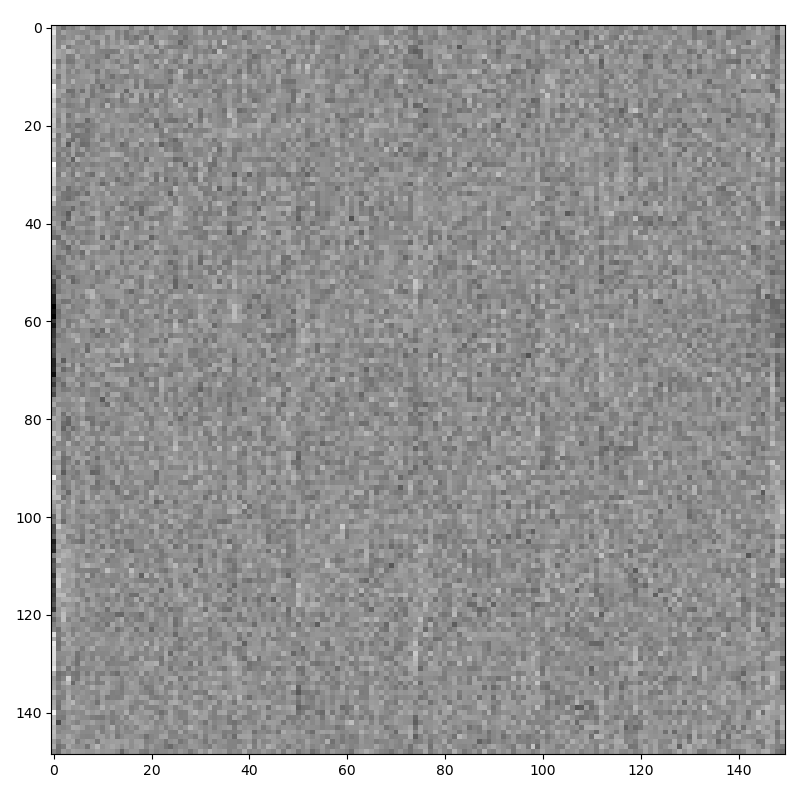

In [102]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(frt_sino, cmap='gray')
F.tight_layout()

In [103]:
img_crop_recon = crop_frt.inv_transform(frt_sino)

In [104]:
img_crop_recon.shape

(149, 149)

C:\Users\lande\AppData\Local\Temp\ipykernel_25596\2101134485.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  F, ax = plt.subplots(1, 2, figsize=(10, 6))


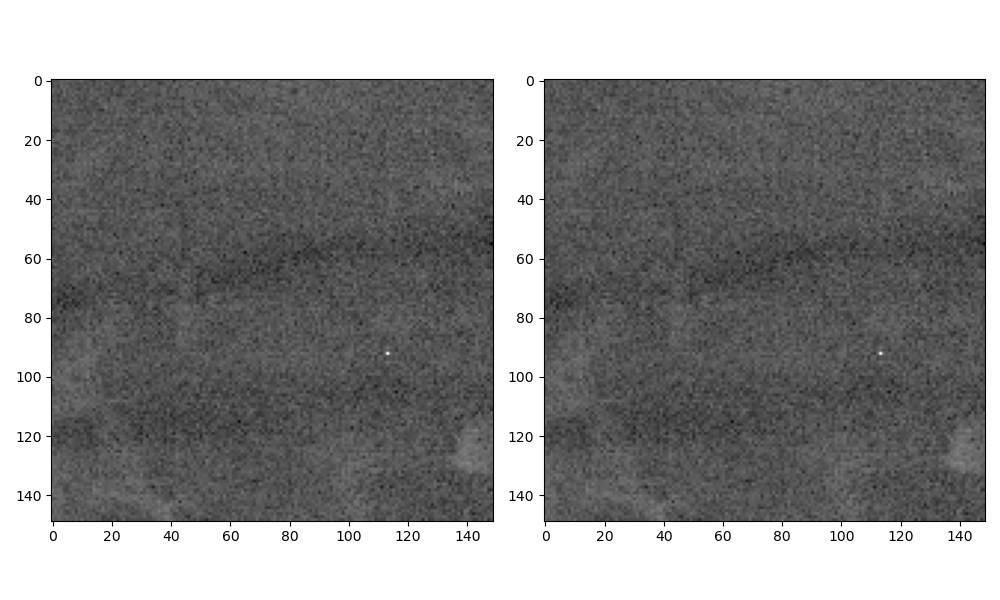

In [105]:
F, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(img_crop, cmap='gray')
ax[1].imshow(img_crop_recon, cmap='gray')
F.tight_layout()

In [106]:
err = img_crop - img_crop.mean() - img_crop_recon

In [109]:
err.min()

3.197442310920451e-13

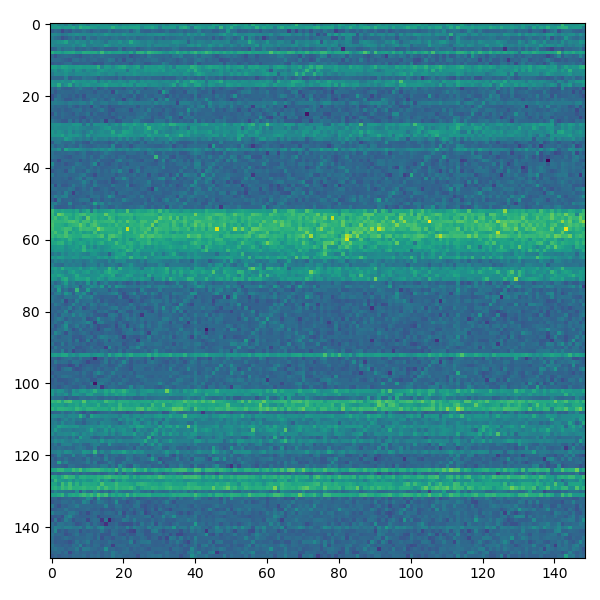

In [108]:
F, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(err, cmap='viridis')
F.tight_layout()

In [44]:
radius = 149 // 2
xx, yy = np.ogrid[-radius:radius + 1, -radius:radius+1]
img_crop[xx**2 + yy**2 > radius**2] = 0

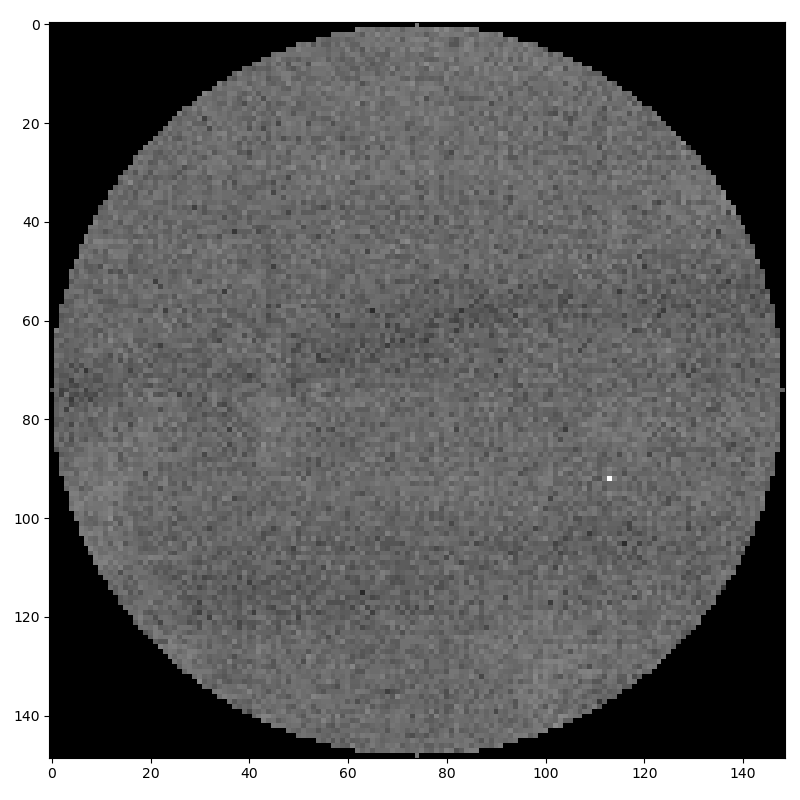

In [46]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_crop, cmap='gray', clim=(0, 255))
F.tight_layout()

In [47]:
theta = np.linspace(0, 180, max(img_crop.shape), endpoint=False)
sinogram = radon(img_crop, theta)

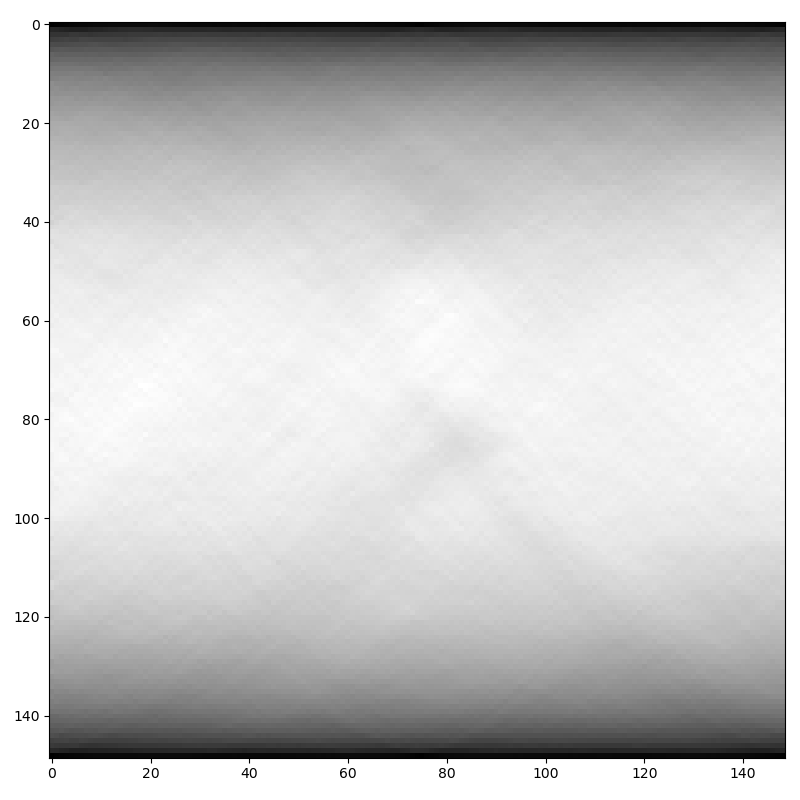

In [48]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(sinogram, cmap='gray')
F.tight_layout()

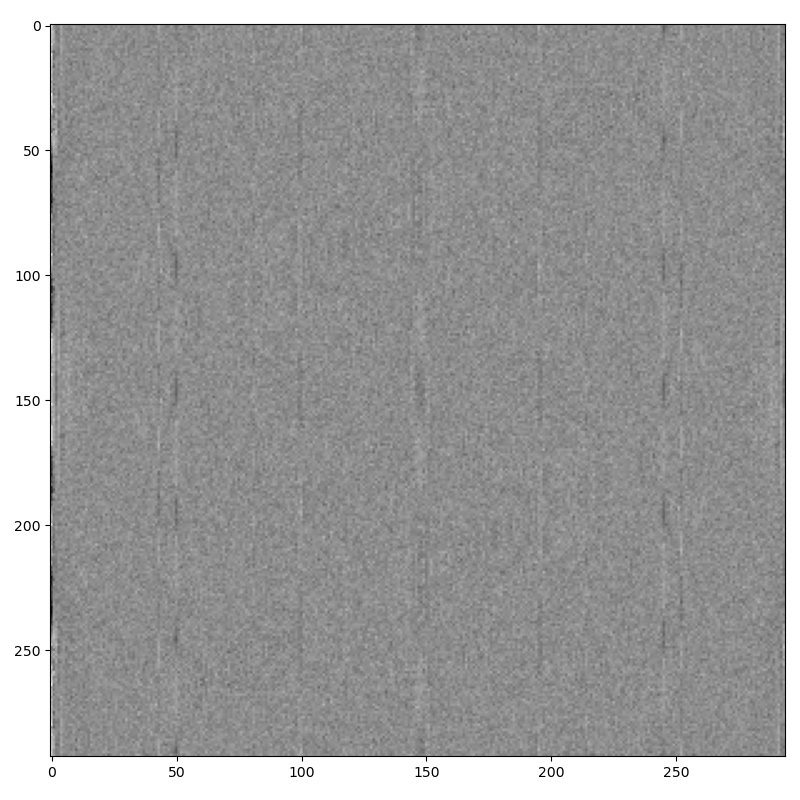

In [282]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(frt_sino, cmap='gray')
F.tight_layout()

In [49]:
img_recon = iradon(sinogram, theta, filter_name='ramp')

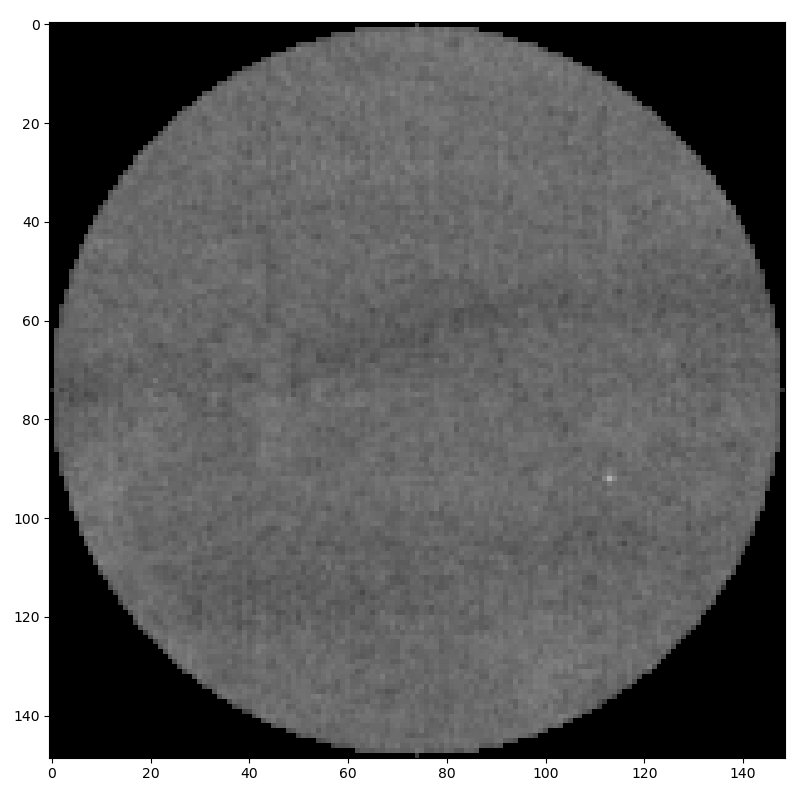

In [51]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_recon, cmap='gray', clim=(0, 255))
F.tight_layout()